In [1]:
################################################
## Import Necessary libraries
################################################
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy.stats import multivariate_normal
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Used in highlighting print statements
BOLD = '\033[1m'
END = '\033[0m'

#Please update as per Dataset path
home = 'C:/Users/Rashpinder/Documents/Python scripts/ML/Datasets/'

import warnings
warnings.filterwarnings('ignore')

## Data Pre-processing

In [2]:
################################################
## 1. Merge Data into one file
## 2. Splitting data into test and train
## 3. Data Normalization
################################################

# function to filter for sds armed only
# Argument: accepts the folder name to be filtered
# Returns: filtered dataset as dataframe
def filter_dataset(folder):
    path = home+folder
    os.chdir(path)
    
    sds_armed_csv = pd.DataFrame([])
    for file_name in glob.glob('*.csv'):
        each_csv = pd.read_csv(file_name)
        each_sds_armed_csv = each_csv[each_csv.Sds_Armed == 1]
        sds_armed_csv = pd.concat([sds_armed_csv, each_sds_armed_csv])
    
    return sds_armed_csv

# Merge data into one file
folder = 'Experiments_with_Anomalies'
anomalies_filtered= filter_dataset(folder)
anomalies_filtered.to_csv( home+"merged_exp_contains_anomalies.csv", index=False, encoding='utf-8-sig')
data = anomalies_filtered
print("Shape of the filtered dataset: ", data)

#Split into features and target
X = data.iloc[:,0:8]  #independent columns
Y = data.iloc[:,-1]    #target column i.e anomaly Tag
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42, stratify = Y)

# Normalize dataset
min_max_scaler = preprocessing.MinMaxScaler()
x_train=min_max_scaler.fit_transform(x_train)
x_test=min_max_scaler.transform(x_test)

Shape of the filtered dataset:  (45626, 10)


## Feature Significance Check

Feature Importance: [0.22868577 0.16156046 0.14597235 0.14625306 0.09582799 0.06908348
 0.07130002 0.08131687]


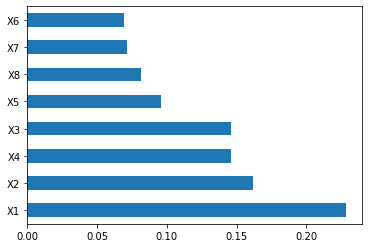

In [3]:
################################################
## Rank the Significance of Each feature
## Extra Trees Classifier
################################################

# fit model
ETmodel = ExtraTreesClassifier(n_estimators=10)
ETmodel.fit(X, Y)

# get significance
imp = ETmodel.feature_importances_
print("Feature Importance:", imp)

# plot significance
feat_importances = pd.Series(imp, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Prediction Models

In [4]:
############################################
## For comparitive analysis
############################################

accuracy_f1={}
accuracy_detection_rate={}
accuracy_false_alarm_rate={}

# function to determine and store accuracies
def get_detection_capabilities(y, y_pred, model_name):
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)

    accuracy_f1[model_name] =  f1_score(y, y_pred)
    accuracy_detection_rate[model_name]= tpr
    accuracy_false_alarm_rate[model_name] = fpr

    print(BOLD, "Classification Report:\n", END, cr)
    print(BOLD, "\nConfusion Matrix:\n", END, cm)
    return

### Multivariate Gaussian

In [5]:
################################################
## Generate Alarm on Gaussian Model
## defining functions
################################################
model_name = 'Multivariate Gaussian'

# function to get the norm functions of test and train
def generateCovModel(X_normal, X_ano):
    mu_normal = np.mean(X_normal, axis=0)
    sigma_normal = np.cov(X_normal.T)

    p_normal = multivariate_normal.pdf(X_normal, mean=mu_normal, cov=sigma_normal)
    p_ano = multivariate_normal.pdf(X_ano, mean=mu_normal, cov=sigma_normal)
    return p_normal, p_ano

# function to determine threshold over train dataset
def determineThreshold(p,Y):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(p) - min(p)) / 1000;
    epsilons = np.arange(min(p),max(p),stepsize)
    for epsilon in np.nditer(epsilons):
        pred = (p < epsilon)
        f = f1_score(Y, pred)
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

# Train and test model
p_train, p_test = generateCovModel(x_train, x_test)
fscore1, ep1 = determineThreshold(p_train,y_train)
y_pred = p_test < ep1

# evaluate model
print("Optimal Epsilon: ", ep1, "\n")
get_detection_capabilities(y_test, y_pred, model_name)

Optimal Epsilon:  46297523.184658445 

 Classification Report:
                precision    recall  f1-score   support

           0       0.92      0.78      0.85     11759
           1       0.31      0.60      0.41      1929

    accuracy                           0.76     13688
   macro avg       0.62      0.69      0.63     13688
weighted avg       0.84      0.76      0.79     13688

 
Confusion Matrix:
  [[9218 2541]
 [ 768 1161]]


### Boosted Trees: XGBoost

In [6]:
################################################
## XGBoost Algorithm
################################################
model_name = 'XGBoost'

# model training and test
model = XGBClassifier() 
model.fit(x_train, y_train)
y_pred=model.predict(x_test)

# evaluate model
get_detection_capabilities(y_test, y_pred, model_name)

 Classification Report:
                precision    recall  f1-score   support

           0       0.93      0.99      0.96     11759
           1       0.87      0.55      0.67      1929

    accuracy                           0.92     13688
   macro avg       0.90      0.77      0.82     13688
weighted avg       0.92      0.92      0.92     13688

 
Confusion Matrix:
  [[11594   165]
 [  864  1065]]


### Clustering Algorithm: K-means

 Classification Report:
                precision    recall  f1-score   support

           0       0.64      0.12      0.20     11759
           1       0.10      0.58      0.17      1929

    accuracy                           0.19     13688
   macro avg       0.37      0.35      0.19     13688
weighted avg       0.56      0.19      0.20     13688

 
Confusion Matrix:
  [[ 1419 10340]
 [  806  1123]]


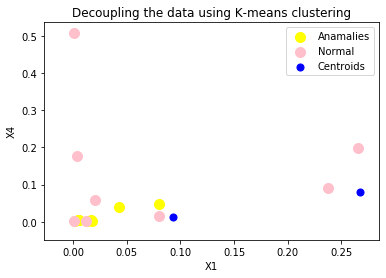

In [7]:
################################################
## K-Means Clustering
################################################
model_name = 'K-means'
np.random.seed(seed=20)

# model training and test
kmeans = KMeans(n_clusters = 2, init='k-means++')
model = kmeans.fit(x_test)
y_pred = kmeans.predict(x_test) 

# evaluate model
get_detection_capabilities(y_test, y_pred, model_name)

# plot of decoupled clusters
columns = data.columns
colors = ['pink', 'yellow']
i1 = 0; i2 = 3
plt.title('Decoupling the data using K-means clustering')
plt.xlabel(columns[i1])
plt.ylabel(columns[i2])
plt.scatter(x_test[y_pred == 1][i1], x_test[y_pred == 1][i2], s = 100, c = 'yellow', label = 'Anamalies')
plt.scatter(x_test[y_pred == 0][i1], x_test[y_pred == 0][i2], s = 100, c = 'pink', label = 'Normal')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 50, c = 'blue', label = 'Centroids')
plt.legend()
plt.show()

## Accuracy Comparison

 

Detection Capabilities
 


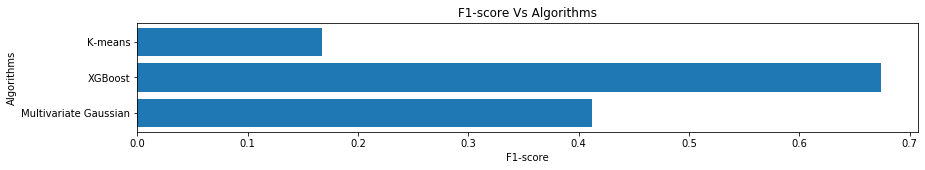

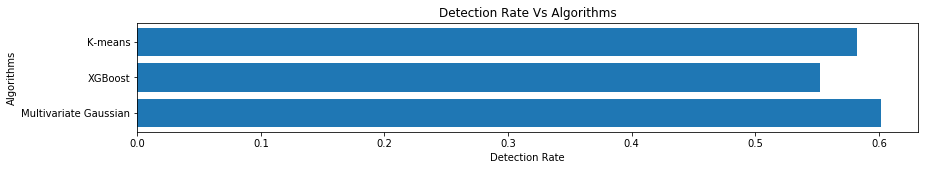

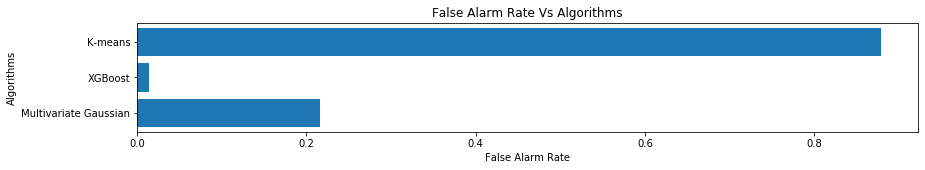

In [8]:
# function to plot the relative accuracies
def plot_analysis(toPlot, title, x_label):
    plt.figure(figsize=(14,2))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Algorithms")
    plt.barh(list(toPlot.keys()), toPlot.values(), align='center')
    plt.show()    
    return

# plotting for accuracy comparison
print(BOLD, "\n\nDetection Capabilities\n", END)
plot_analysis(accuracy_f1, "F1-score Vs Algorithms", "F1-score")
plot_analysis(accuracy_detection_rate, 'Detection Rate Vs Algorithms', "Detection Rate")
plot_analysis(accuracy_false_alarm_rate, "False Alarm Rate Vs Algorithms", "False Alarm Rate")